# Distribution of thermodynamics

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('../../')
import scripts.icon_mcrph_func as imf

## 1. Data

In [10]:
# path to store figures:
fig_path='../../../plots/publication_plots/paper_wrapper_2023/'

Datasets for fig. 1

In [3]:
datapath_pn = '/scratch/tkiszler/low_clouds_datasets/polar_night/'
datapath_pd = '/scratch/tkiszler/low_clouds_datasets/polar_day/'

ds = xr.open_mfdataset(glob.glob(datapath_pn + "LLC_meteo*_ICONv1_v6.nc")+ \
                       glob.glob(datapath_pd + "LLC_meteo*_ICONv1_v6.nc"),
                   combine='by_coords', engine='netcdf4', parallel=True, chunks={'time': 'auto'})
level_idx = 111
ds_levsel = ds.isel(height_2=slice(level_idx,None), height=slice(level_idx,-1))
# compute saturation vapour pressure in respect to ice and liquid water
#ds_levsel['sat_i'] = ds_levsel['QV'].copy(deep=True)
#ds_levsel['sat_i'].values = np.zeros(ds_levsel['sat_i'].shape)
ds_levsel['sat_i'] = xr.DataArray(np.zeros(ds_levsel['QV'].shape),
                                dims=('time', 'height_2'))
ds_levsel['sat_i'].values[:-1,:] = imf.saturation_ice(ds_levsel['T'].values[1:,:],
                                                  ds_levsel['QV'].values[:-1,:], ds_levsel['RHO'].values[:-1,:])
ds_levsel['sat_w'] = xr.DataArray(np.zeros(ds_levsel['QV'].shape),
                                dims=('time', 'height_2'))
ds_levsel['sat_w'].values[:-1,:] = imf.saturation_water(ds_levsel['T'].values[1:,:],
                                                    ds_levsel['QV'].values[:-1,:], ds_levsel['RHO'].values[:-1,:])

# convert temp from K to C, the ICON units are in K for computations of saturation etc.!
ds_levsel['T'] = ds_levsel['T'] - 273.15

# split liquid and frozen mass
ds_levsel['liquid_mass'] = ds.QR  + ds.QC
ds_levsel['frozen_mass'] = ds.QI + ds.QS + ds.QG + ds.QH

In [4]:
ds_pn = ds_levsel.sel(time=slice('2021-11-01', '2022-02-28'))
ds_pd = ds_levsel.sel(time=slice('2021-05-01', '2021-08-31'))

Data frames for fig. 2

In [5]:

# load data if it has been saved
df_fr_mass_pn = pd.read_csv('../../../data/processed/df_frozen_mass_T_W_SI_NDJF_W2122.csv')
df_li_mass_pn = pd.read_csv('../../../data/processed/df_liquid_mass_T_W_SI_NDJF_W2122.csv')

df_fr_mass_pd = pd.read_csv('../../../data/processed/df_frozen_mass_T_W_SI_MJJA_S21.csv')
df_li_mass_pd = pd.read_csv('../../../data/processed/df_liquid_mass_T_W_SI_MJJA_S21.csv')

# compine the dataframes for the two seasons
df_fr_mass = pd.concat([df_fr_mass_pn, df_fr_mass_pd])
df_li_mass = pd.concat([df_li_mass_pn, df_li_mass_pd])

## 2. Plots

In [6]:
# define bins for temp, w, sat_i
temp_bins = np.arange(-35, 10, 2)
w_bins = np.arange(-3, 3, 0.1)
sat_i_bins = np.arange(0,1.5, 0.05)
# create logarithmic bins for mass
mass_bins = np.arange(-8, -2.5, 0.2)

# Combine the data from both DataFrames into a single histogram
hist_liq_T, xbins_T, ybins_T = np.histogram2d(df_li_mass['T'], np.log10(df_li_mass['liquid mass']), bins=(temp_bins, mass_bins))
hist_frozen_T, _, _ = np.histogram2d(df_fr_mass['T'], np.log10(df_fr_mass['frozen mass']), bins=(temp_bins, mass_bins))
hist_liq_w, xbins_w, ybins_w = np.histogram2d(df_li_mass['W'], np.log10(df_li_mass['liquid mass']), bins=(w_bins, mass_bins))
hist_frozen_w, _, _ = np.histogram2d(df_fr_mass['W'], np.log10(df_fr_mass['frozen mass']), bins=(w_bins, mass_bins))
hist_liq_sat_i, xbins_sat_i, ybins_sat_i = np.histogram2d(df_li_mass['sat_i'], np.log10(df_li_mass['liquid mass']), bins=(sat_i_bins, mass_bins))
hist_frozen_sat_i, _, _ = np.histogram2d(df_fr_mass['sat_i'], np.log10(df_fr_mass['frozen mass']), bins=(sat_i_bins, mass_bins))

# Normalize the histogram values to get frequencies/percentages
perc_liq_T = hist_liq_T / len(df_li_mass) *100
perc_frozen_T = hist_frozen_T / len(df_fr_mass) *100
perc_liq_w = hist_liq_w / len(df_li_mass) *100
perc_frozen_w = hist_frozen_w / len(df_fr_mass) *100
perc_liq_sat_i = hist_liq_sat_i / len(df_li_mass) *100
perc_frozen_sat_i = hist_frozen_sat_i / len(df_fr_mass) *100

In [7]:
cloudy_pn = (ds_pn.QI.values+ds_pn.QC.values + ds_pn.QR.values+ds_pn.QS.values +
            ds_pn.QH.values+ds_pn.QG.values) >= 1e-8
cloudy_pd = (ds_pd.QI.values+ds_pd.QC.values + ds_pd.QR.values+ds_pd.QS.values +
            ds_pd.QH.values+ds_pd.QG.values) >= 1e-8

cloudy = np.concatenate((cloudy_pn, cloudy_pd))

### 2.1 Total distribution Temp, w, sat_i

In [11]:
# create a histogram of the temperature, w, and sat_i for the polar night
sns.set_style('whitegrid')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

# temp
sns.histplot(ax=ax[0], x=ds_pn.T.values[cloudy_pn],
                              bins=temp_bins, color='maroon', stat='percent',
                              kde=True)
sns.histplot(ax=ax[0], x=ds_pd.T.values[~cloudy_pd],
                                bins=temp_bins, color='steelblue', stat='percent',
                                kde=True)
ax[0].set_xlabel('(a) Temperature ($^{\circ}$C)')
ax[0].set_ylabel('Percent (%)')

# w
sns.histplot(ax=ax[1], x=ds_pn.W.values[cloudy_pn],
                              bins=w_bins, color='maroon',
                              stat='percent', kde=True, label='Polar night')
sns.histplot(ax=ax[1], x=ds_pd.W.values[cloudy_pd],
                                bins=w_bins, color='steelblue',
                                stat='percent', kde=True, label='Polar day')
ax[1].set_xlabel('(b) Vertical Velocity (m/s)')
ax[1].set_ylabel('')
ax[1].set_xlim(-2,2)
# add legend to ax[1]
ax[1].legend(loc='upper right')

# sat_i
sns.histplot(ax=ax[2],x=ds_pn.sat_i.values[cloudy_pn], bins=sat_i_bins,
                              color='maroon', stat='percent',
                              kde=True)
sns.histplot(ax=ax[2],x=ds_pd.sat_i.values[cloudy_pd], bins=sat_i_bins,
                                color='steelblue', stat='percent',
                                kde=True)
ax[2].set_xlabel('(c) Saturation (ice)')
ax[2].set_ylabel('')
ax[2].set_xlim(0.4,1.3)

#plt.suptitle('Polar Night vs Polar Day')

plt.tight_layout()
#plt.savefig(fig_path+'temp_w_sat_i_hist_cloudy_cases_pn_pd.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_path+'fig_02_temp_w_sat_i_hist_cloudy_cases_pn_pd.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()


### 2.2 Contour plot fig 2

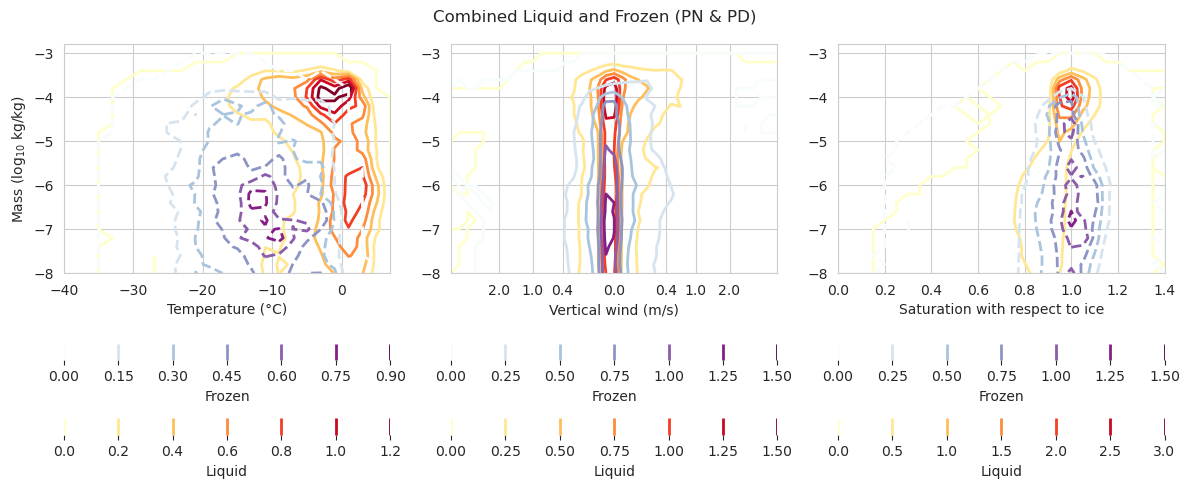

In [13]:
sns.set_style('whitegrid')
# Create the figure and subplot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

common_levels = np.linspace(0.2, 1.2, 8)
# Plot the combined contour plots for liquid and frozen mass in the same subplot
cmap_liq = ax[0].contour(xbins_T[:-1], ybins_T[:-1], perc_liq_T.T, cmap='YlOrRd', levels=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2],
                      linewidths=2)
cmap_frozen = ax[0].contour(xbins_T[:-1], ybins_T[:-1], perc_frozen_T.T, cmap='BuPu', levels=[0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9],
                         linewidths=2, linestyles='dashed')

ax[0].set_xlabel('Temperature (°C)')
ax[0].set_ylabel(r'Mass (log$_{10}$ kg/kg)')
# make more ticks on the x axis
ax[0].set_xticks([-40,-30,-20,-10,0])
# add two colorbars
cbar_liq = fig.colorbar(cmap_liq, ax=ax[0], label='Liquid', location='bottom', pad=0.05)
cbar_liq.outline.set_edgecolor('None')
cbar_fr = fig.colorbar(cmap_frozen, ax=ax[0], label='Frozen', location='bottom', pad=0.2)
cbar_fr.outline.set_edgecolor('None')

## Wind
wind_power = 0.5 # make smaller values more visible
cmap_liq = ax[1].contour(xbins_w[:-1], ybins_w[:-1], perc_liq_w.T**wind_power, cmap='YlOrRd', levels=5,
                        linewidths=2)
cmap_frozen = ax[1].contour(xbins_w[:-1], ybins_w[:-1], perc_frozen_w.T**wind_power, cmap='BuPu', levels=5,
                            linewidths=2, linestyles='solid')
ax[1].set_xlabel('Vertical wind (m/s)')
cbar_liq= fig.colorbar(cmap_liq, ax=ax[1], label='Liquid', location='bottom', pad=0.05)
cbar_liq.outline.set_edgecolor('None')
cbar_fr = fig.colorbar(cmap_frozen, ax=ax[1], label='Frozen', location='bottom', pad=0.2)
cbar_fr.outline.set_edgecolor('None')

# Function to apply inverse power transformation to get the original wind speed values for x-axis ticks
def inverse_transform(x):
    return x ** (1 / wind_power)
# Set the x-axis ticks using the inverse transformation
ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{inverse_transform(x):.1f}'))
ax[1].set_xticks([-2**wind_power,-1**wind_power,-0.4**wind_power,0,0.4**wind_power,1**wind_power,2**wind_power])  # Set custom x-axis ticks
ax[1].set_xlim([-2,2])  # Set custom x-axis limits

## sat_i
cmap_liq = ax[2].contour(xbins_sat_i[:-1], ybins_sat_i[:-1], perc_liq_sat_i.T, cmap='YlOrRd', levels=5,
                        linewidths=2)
cmap_frozen = ax[2].contour(xbins_sat_i[:-1], ybins_sat_i[:-1], perc_frozen_sat_i.T, cmap='BuPu', levels=5,
                            linewidths=2, linestyles='dashed') 
ax[2].set_xlabel('Saturation with respect to ice')
#cax_liq = inset_axes(axs[2], width="50%", height="5%", loc='lower left', bbox_to_anchor=(0, -0, 1, 1), bbox_transform=axs[0].transAxes)
cbar_liq = fig.colorbar(cmap_liq, ax=ax[2], label='Liquid', 
             location='bottom', pad=0.05)
cbar_liq.outline.set_edgecolor('None')
cbar_fr = fig.colorbar(cmap_frozen, ax=ax[2], label='Frozen', location='bottom', pad=0.2)
cbar_fr.outline.set_edgecolor('None')

plt.suptitle('Combined Liquid and Frozen (PN & PD)')

plt.tight_layout()
plt.savefig(fig_path + 'mass_vs_w_temp_sat_i.png', dpi=300, format='png',
           bbox_inches='tight')
plt.show()


## 3. Numbers 

In [14]:
# get statistical numbers for these distributions
# 1. temperature
temp = ds_levsel['T'].values
print('Temperature')
print('mean: ', np.nanmean(temp))
print('std: ', np.nanstd(temp))
print('median: ', np.nanmedian(temp))
print('min: ', np.nanmin(temp))
print('max: ', np.nanmax(temp))
print('')
# 2. vertical velocity
w = ds_levsel['W'].values
print('Vertical velocity')
print('mean: ', np.nanmean(w))
print('std: ', np.nanstd(w))
print('median: ', np.nanmedian(w))
print('min: ', np.nanmin(w))
print('max: ', np.nanmax(w))
print('')
# 3. sat_i
sat_i = ds_levsel['sat_i'].values
print('sat_i')
print('mean: ', np.nanmean(sat_i))
print('std: ', np.nanstd(sat_i))
print('median: ', np.nanmedian(sat_i))
print('min: ', np.nanmin(sat_i))
print('max: ', np.nanmax(sat_i))
print('')


Temperature
mean:  -7.489534909326483
std:  8.282404434017074
median:  -6.914517102573541
min:  -32.316409099333754
max:  8.09315213314585

Vertical velocity
mean:  0.03525813423887124
std:  0.29324318192855203
median:  0.0015430750765087296
min:  -4.5584817725262825
max:  6.4328833148282145

sat_i
mean:  0.8449018898424997
std:  0.21517666593073656
median:  0.896476505397807
min:  0.0
max:  3.5912300607667045

